# Fig 3 (II) - Quantifying and modelling the effects of sequence features on CDS TE

## Dataset

In [1]:
# s = "mm"
# stage = "mES"
# ASSEMBLY = "GRCm38_ens"

# s = "dr"
# stage = "Shield"
# ASSEMBLY = "Zv9_ens"

s = "hs"
stage = "HeLa"
ASSEMBLY = "GRCh37_ens"

## Imports, parameters and functions

In [2]:
# FILTER PARAMETERS
UTR5_LENGTH_MIN = 25
UTR3_LENGTH_MIN = 25

FPKM_MIN = 0.1
CDS_LENGTH_MIN = 100
CDS_READS_MIN = 1

UORF_LENGTH_MIN = 20
UORF_FROM_TRANSCRIPT_START_MIN = UTR5_LENGTH_MIN
UORF_READS_MIN = 1

UTR5_READS_MIN = 1

ORF_END_TRIM = 10

In [3]:
# IMPORTS
import corebio
import weblogolib

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn.apionly as sns

from Bio import SeqIO
from IPython.display import display, HTML, Markdown, Image
from ast import literal_eval
from numpy import argmax, mean, log10, log2, inf, nan, array, float64, subtract, multiply, divide, sign
from pandas import Panel, DataFrame, Series
from pandas.stats.moments import rolling_mean
from scipy.stats import spearmanr, ks_2samp, pearsonr, linregress, zscore, kendalltau, kde
from scipy.stats.mstats import trimboth
from sklearn.linear_model import Ridge, RidgeCV
from statsmodels.distributions import ECDF
from statsmodels.nonparametric.smoothers_lowess import lowess

%matplotlib inline

In [4]:
pd.options.display.mpl_style = 'default'
pd.options.mode.chained_assignment = None
mpl.rcParams['figure.figsize'] = 8, 6
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.facecolor'] = "#fdfdfd"
mpl.rcParams['grid.alpha'] = 0.5
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['savefig.dpi'] = 50

In [5]:
C_NT = ("#00d700", "#df1f00", "#0226cc", "#ffb700")
C_UORF = ('#b30000', '#e34a33', '#fc8d59', '#fdbb84', '#fdd49e')
C_CDS = ("#105e47", "#157e5f", "#1b9e77", "#48b192", "#76c4ad")
C_RATIO = "#7570b3"
C_BG = ("#000000", "#525252", "#969696", "#d9d9d9")
C_SP = {"hs": "#97543a", "mm": "#546079", "dr": "#3d7463"}
C_SP_BAR = {"hs": "#fc8d62", "mm": "#8da0cb", "dr": "#66c2a5"}
C_NOBIAS = "#ffd92f"
C_SCATTER = "#737373"
C_TREND = "#e41a1c"
C_TLOC = {"5' UTR": "#d95f02", "CDS start": "#1b9e77", "CDS internal": "#e7298a", "3' UTR": "#e6ab02"}
C_STARTS = ("#276419", "#4d9221", "#7fbc41")
C_STOPS = ("#8e0152", "#c51b7d", "#de77ae")

In [6]:
def scatter_linear_trend(x, y, x_label, y_label, plot_trend=True, corr_table=True):
    data = DataFrame({"x": x, "y": y}).dropna()
    
    plt.figure()
    plt.scatter(data.x, data.y, alpha=0.25, c=C_SCATTER)

    mod = Ridge(normalize=False).fit(zip(*[data.x,]), data.y)
    x1, x2 = (np.percentile(data.x, 2.5), np.percentile(data.x, 97.5))
    y1, y2 = mod.predict([(x1,), (x2,)])
    
    plt.ylim(np.percentile(data.y, 1), np.percentile(data.y, 99))
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    if plot_trend:
        plt.plot((x1, x2), (y1, y2), c=C_TREND, lw=2)

    if corr_table:
        to_display = DataFrame(columns=["Correlation\ncoefficient", "p-value"])

        corr, p = pearsonr(data.x, data.y)
        to_display.loc["Pearson linear"] = {"Correlation\ncoefficient": corr,
                                    "p-value": p}
        corr, p = spearmanr(data.x, data.y)
        to_display.loc["Spearman rank"] = {"Correlation\ncoefficient": corr,
                                  "p-value": p}

        display(Markdown(y_label + " against " + x_label))
        display(to_display.applymap('{:,.4g}'.format))
    
    return abs(y2 - y1), sign(y2 - y1)

In [7]:
def flatten(i):
    return [j for k in i for j in k]

def clean(i):
    return i.replace([-inf, inf], nan).dropna()

def z(i):
    return (i - i.mean()) / i.std(ddof=0)

In [8]:
def individual_correlations(parameter_set_names_to_correlate, parameter_sets, data_set_name, data_set):
    to_display = DataFrame(columns=["linear correlation", "p", "fold change over 95% of data"])
    
    colors = flatten([[parameters[i][3] for j in range(len(parameters[i][0]))] for i in parameter_set_names_to_correlate])
    
    for set_name in parameter_set_names_to_correlate:
        for parameter, label, limits, _ in zip(*parameters[set_name]):
            if parameter not in data_set.columns:
                continue

            data = clean(data_set[[parameter, "log2_CDS_TE"]])
            
            corr, p = pearsonr(data[parameter], data.log2_CDS_TE)
            
            plt.figure()
            plt.scatter(data[parameter], data.log2_CDS_TE, alpha=0.25, c=C_SCATTER)
            
            plt.xlabel(label)
            plt.ylabel("log2 CDS TE")
            
            plt.xlim(*limits)
            plt.ylim(-8, 0)
            plt.title(data_set_name)
            mod = Ridge(normalize=False).fit(zip(*[data[parameter],]), data.log2_CDS_TE)
            
            x1, x2 = (np.percentile(data[parameter], 2.5), np.percentile(data[parameter], 97.5))
            y1, y2 = mod.predict([(x1,), (x2,)])
            
            plt.plot((x1, x2), (y1, y2), c=C_TREND, lw=2)

            to_display.loc[label] = {"linear correlation": corr, "p": p,
                                     "fold change over 95% of data": 2**(y2 - y1)}

    display(Markdown("### Individual correlations with CDS TE, " + data_set_name[:1].lower() + data_set_name[1:]))
    display(to_display.iloc[::-1].applymap('{:,.4g}'.format))
    
    plt.figure(figsize=(6, 0.75 + float(len(to_display)) * .3))
    ax = to_display["fold change over 95% of data"].apply(log2).plot(kind="barh", width=0.9, color=colors)
    ax.set_xlabel("log2 fold change over 95% of data")

In [9]:
def lin_regress_sets_RidgeCV(regressor_sets, parameter_sets, data_set_name, data_set,
                             parameter_to_regress, to_regress_label, limits, limits_coeff):
    
    to_display1 = DataFrame(columns=["Pearson r", "p", "Fold change", "PRESS", "RESS", "n"])
    
    sets_to_regress = list(set(flatten(regressor_sets)))
    regressors = [i + "_Z" for i in flatten([parameters[i][0] for i in sets_to_regress])]
    data = data_set[regressors + [parameter_to_regress]].dropna()
    
    for regressor_set in regressor_sets:
        
        regressors = [i + "_Z" for i in flatten([parameter_sets[i][0] for i in regressor_set])]
        regressor_labels = [i for i in flatten([parameter_sets[i][1] for i in regressor_set])]
        colors = flatten([[parameter_sets[i][3] for j in range(len(parameter_sets[i][0]))] for i in regressor_set])

        mod = RidgeCV(normalize=False, store_cv_values=True).fit(data[regressors], data[parameter_to_regress])
        combined_score = np.sum([data[i].multiply(j) for i, j in zip(regressors, mod.coef_)], axis=0)
        
        plt.figure()
        plt.scatter(combined_score, data[parameter_to_regress], alpha=0.25, c=C_SCATTER)
        plt.xlabel("+".join(regressor_set) + " combined score")
        plt.ylabel(to_regress_label)
        plt.xlim(*limits[0])
        plt.ylim(*limits[1])
        plt.title(data_set_name)

        corr, p = pearsonr(combined_score, data[parameter_to_regress])

        x1, x2 = [np.percentile(combined_score, i) for i in [2.5, 97.5]]
        predicted = mod.predict(data[regressors])
        y1, y2 = [np.percentile(predicted, i) for i in [2.5, 97.5]]
        plt.plot((x1, x2), (y1, y2), c=C_TREND, lw=2)
        
        to_display1.loc[" + ".join(regressor_set)] = {"Pearson r": corr, "p": p,
                                                      "Fold change": 2**(y2-y1),
                                                      "PRESS": sum(mod.cv_values_)[0],
                                                      "RESS": sum((predicted - data[parameter_to_regress]) ** 2),
                                                      "n": len(data[parameter_to_regress])}
        
        display(Markdown(" + ".join(regressor_set) + " sequence features"))
        to_display = DataFrame(columns=["Relative contribution", "per unit 2fold change"])
        for i, label, j in zip(regressors, regressor_labels, mod.coef_):
            to_display.loc[label] = {"Relative contribution": j,
                                     "per unit 2fold change": data_set[i[:-2]].std() * j}
        to_display.index.name = "Sequence feature"
        display(to_display.iloc[::-1].applymap('{:,.4g}'.format))
        
        plt.figure(figsize=(6, 0.75 + float(len(to_display)) * .3))
        ax = to_display["Relative contribution"].plot(kind="barh", width=0.9, color=colors)
        ax.set_xlabel("Relative contribution")
        plt.xlim(*limits_coeff)
        plt.title("CDS TE")
        print
    to_display1.index.name = "Sequence feature set"
    display(to_display1.applymap('{:,.4g}'.format))

In [10]:
def scatter_by_uORF_num(dataset, dataset_label, para_x, para_y,
                        para_x_label, para_y_label, x_limits, y_limits):
    subset_labels = ["1 uORF", "2 uORFs", "3 uORFs", "4+ uORFs"]
    plt.figure()
    data = dataset[[para_x, para_y]]
    data["num_uORF"] = dataset.num_uORFs.apply(lambda x: min(x, 4))
    data = clean(data)

    cmap = mpl.colors.ListedColormap(C_UORF[:-1])

    fig, ax = plt.subplots()
    fig1 = ax.scatter(data[para_x], data[para_y], c=data.num_uORF, s=15,
                      cmap=cmap, vmax=data.num_uORF.max(), alpha=0.3)

    for num_uORF, color in zip([1, 2, 3, 4], C_UORF[:-1]):
        sns.kdeplot(data[para_x][data.num_uORF == num_uORF], data[para_y][data.num_uORF == num_uORF],
                    n_levels=5, cmap=None, colors=color, linewidths=[0,3,0,0,0], alpha=1)
        
    
    sns.kdeplot(data[para_x], data[para_y], n_levels=5, cmap=None,
                colors=C_SCATTER, linewidths=[0,3,0,0,0], alpha=1)

    cbar = fig.colorbar(fig1, ticks=[np.arange(0.4, 5, 0.8)])
    cbar.ax.set_yticklabels(subset_labels)

    plt.xlabel(para_x_label)
    plt.ylabel(para_y_label)
    plt.legend(loc="upper left")
    plt.xlim(*x_limits)
    plt.ylim(*y_limits)
    plt.title(dataset_label)
    
    to_display = DataFrame(columns=["Correlation\ncoefficient", "p-value"])

    for num_uORF, label in zip((1, 2, 3, 4), subset_labels):
        corr, p = pearsonr(data[para_x][data.num_uORF == num_uORF],
                           data[para_y][data.num_uORF == num_uORF])
        to_display.loc[label] = {"Correlation\ncoefficient": corr,
                                                   "p-value": p}
    corr, p = pearsonr(data[para_x], data[para_y])
    to_display.loc["All"] = {"Correlation\ncoefficient": corr,
                                "p-value": p}
    display(Markdown(para_y_label + " against " + para_x_label))
    display(to_display.applymap('{:,.4g}'.format))

## Reading in ORF characteristics data

In [11]:
DATA_DIR = "./data/" + s + "/"
ANNOTATIONS_DIR = "./annotations/"

In [12]:
CONVERTERS = {i:literal_eval for i in ("uORFs_reads", "uORFs_length", "uORFs_wrent_score", "uORFs_urent_score",
                                       "uORFs_wrent_seq", "uORFs_sec_struct_EFE_L", "uORFs_sec_struct_EFE_R",
                                       "uORFs_start_pos_wrt_tss", "uORFs_end_pos_wrt_CDS",
                                       "ORFs_wrent_score", "ORFs_urent_score", "ORFs_wrent_seq",
                                       "ORFs_sec_struct_EFE_L", "ORFs_sec_struct_EFE_R")}

In [13]:
stage_species = {"mES": "mm", "HeLa": "hs", "Shield": "dr"}
mean_ssefes = pd.read_table(DATA_DIR + stage_species[stage] + "_mean_ssefes.df", sep="\t", index_col=[0])

In [14]:
windows = [25, 30, 35, 40]
df_main = pd.read_csv(DATA_DIR + stage + "_main.df", index_col="Transcript", sep="\t", converters=CONVERTERS)
for window in windows:
    for pos in ("UTR5", "CDS"):
        field = pos + "_mean_ssefe_" + str(window)
        df_main[field] = mean_ssefes[field][mean_ssefes.index.isin(df_main.index)]
        df_main[field + "_Z"] = z(df_main[field])

In [15]:
df_main_filtered = df_main[(df_main.UTR5_length >= UTR5_LENGTH_MIN) &
                           (df_main.UTR3_length >= UTR3_LENGTH_MIN) &
                           (df_main.Gene_Expression_FPKM >= FPKM_MIN) &
                           (df_main.CDS_length >= CDS_LENGTH_MIN) &
                           (df_main.CDS_reads >= CDS_READS_MIN) &
                           (df_main.UTR5_reads_trunc >= UTR5_READS_MIN)]

In [16]:
df_main_filtered["CDS_density"] = df_main_filtered.CDS_reads / \
                                  df_main_filtered.CDS_length.subtract(ORF_END_TRIM)

df_main_filtered["CDS_TE"] = df_main_filtered.CDS_density / \
                             df_main_filtered.Gene_Expression_FPKM

df_main_filtered["log2_CDS_density"] = log2(df_main_filtered.CDS_density)

df_main_filtered["log2_CDS_TE"] = log2(df_main_filtered.CDS_TE)

df_main_filtered["num_uORFs"] = df_main_filtered.num_uORFs.replace([0], 0.1)

df_main_filtered["num_uORFs_density"] = df_main_filtered.num_uORFs.apply(float) / \
                                        df_main_filtered.UTR5_length

for parameter in ("CDS_TE", "CDS_length", "UTR5_length", "Gene_Expression_FPKM", "num_uORFs_density"):
    df_main_filtered["log_" + parameter] = clean(log10(df_main_filtered[parameter].apply(float)))
    df_main_filtered["log_" + parameter + "_Z"] = z(df_main_filtered["log_" + parameter])

for parameter in ("CDS_wrent_score", "CDS_sec_struct_EFE_L", "CDS_sec_struct_EFE_R",
                  "UTR5_GC", "CDS_GC", "num_uORFs"):
    df_main_filtered[parameter + "_Z"] = z(df_main_filtered[parameter])

## Restricting uORF sequence feature effect analyses to transcripts with only one non-overlapping uORF

In [17]:
no_uORFs = df_main_filtered[df_main_filtered.num_uORFs < 1]
with_uORFs = df_main_filtered[df_main_filtered.num_uORFs >= 1]
one_uORF = df_main_filtered[df_main_filtered.num_uORFs == 1]
two_uORF = df_main_filtered[df_main_filtered.num_uORFs == 2]
three_uORF = df_main_filtered[df_main_filtered.num_uORFs == 3]

for parameter in ("CDS_TE", "CDS_length", "UTR5_length", "Gene_Expression_FPKM", "num_uORFs_density"):
    no_uORFs["log_" + parameter + "_Z"] = z(no_uORFs["log_" + parameter])

for parameter in ("CDS_wrent_score", "CDS_sec_struct_EFE_L", "CDS_sec_struct_EFE_R", "UTR5_GC", "CDS_GC", "num_uORFs"):
    no_uORFs[parameter + "_Z"] = z(no_uORFs[parameter])

for parameter in ("CDS_TE", "CDS_length", "UTR5_length", "Gene_Expression_FPKM", "num_uORFs_density"):
    with_uORFs["log_" + parameter + "_Z"] = z(with_uORFs["log_" + parameter])

for parameter in ("CDS_wrent_score", "CDS_sec_struct_EFE_L", "CDS_sec_struct_EFE_R", "UTR5_GC", "CDS_GC", "num_uORFs"):
    with_uORFs[parameter + "_Z"] = z(with_uORFs[parameter])

In [18]:
# Creates set of 1 non-overlapping uORF
one_non_overlapping_uORF = df_main_filtered[(df_main_filtered.num_uORFs == 1)]   # 1 uORF

# Since set has only transcripts with 1 uORF, "singularize" some columns of data
for variable in ("uORFs_reads", "uORFs_length", "uORFs_wrent_score", "uORFs_urent_score",
                 "uORFs_sec_struct_EFE_L", "uORFs_sec_struct_EFE_R", "uORFs_start_pos_wrt_tss",
                 "uORFs_end_pos_wrt_CDS"):
    one_non_overlapping_uORF[variable] = one_non_overlapping_uORF[variable].apply(lambda x:x[0])

# Filter set for non-overlapping uORF, with uORFs of minimum length, reads and distance from transcript start
one_non_overlapping_uORF = one_non_overlapping_uORF[\
    (one_non_overlapping_uORF.uORFs_end_pos_wrt_CDS < 0) &
    (one_non_overlapping_uORF.uORFs_reads >= UORF_READS_MIN) &
    (one_non_overlapping_uORF.uORFs_length >= UORF_LENGTH_MIN) &
    (one_non_overlapping_uORF.uORFs_start_pos_wrt_tss >= UORF_FROM_TRANSCRIPT_START_MIN)]
print "Number of one non-overlapping uORF Transcripts = %d" % len(one_non_overlapping_uORF)

# Calculate uORF TEs for set
one_non_overlapping_uORF["uORF_TE"] = one_non_overlapping_uORF.apply(lambda x: float64(x.uORFs_reads) \
                                                                               / (x.uORFs_length - ORF_END_TRIM) \
                                                                               / x.Gene_Expression_FPKM, axis=1)

Number of one non-overlapping uORF Transcripts = 677


In [19]:
one_non_overlapping_uORF["uORF_CDS_log_dist"] = one_non_overlapping_uORF.uORFs_end_pos_wrt_CDS.apply(lambda x:log10(-x))

for parameter in ("uORFs_length", "uORFs_start_pos_wrt_tss"):
    one_non_overlapping_uORF["log_" + parameter] = log10(one_non_overlapping_uORF[parameter].apply(float))
    one_non_overlapping_uORF["log_" + parameter + "_Z"] = z(one_non_overlapping_uORF["log_" + parameter])

for parameter in ("uORFs_wrent_score", "uORFs_sec_struct_EFE_L", "uORFs_sec_struct_EFE_R", "uORF_CDS_log_dist"):
    one_non_overlapping_uORF[parameter + "_Z"] = z(one_non_overlapping_uORF[parameter])

for parameter in ("CDS_TE", "CDS_length", "UTR5_length", "Gene_Expression_FPKM", "num_uORFs_density"):
    one_non_overlapping_uORF["log_" + parameter + "_Z"] = z(one_non_overlapping_uORF["log_" + parameter])

for parameter in ("CDS_wrent_score", "CDS_sec_struct_EFE_L", "CDS_sec_struct_EFE_R", "UTR5_GC", "CDS_GC", "num_uORFs"):
    one_non_overlapping_uORF[parameter + "_Z"] = z(one_non_overlapping_uORF[parameter])

## Figures

### Integrating various sequence features in linear models

In [20]:
parameters = {"CDS": (("CDS_wrent_score", 
                       "CDS_sec_struct_EFE_L", "CDS_sec_struct_EFE_R", "CDS_mean_ssefe_35"),
                      ("CDS WRENT score", 
                       "CDS start sec struct EFE left", "CDS start sec struct EFE right", "CDS mean sec struct EFE"),
                      ((-6, 6), (-18, 0), (-18, 0), (-11, -3)),
                      C_TLOC["CDS start"]),
              "uORF": (("uORFs_wrent_score", "uORFs_sec_struct_EFE_L", "uORFs_sec_struct_EFE_R",
                        "uORF_CDS_log_dist", "log_uORFs_length", "log_uORFs_start_pos_wrt_tss"),
                       ("uORF WRENT score", "uORF start sec struct EFE left", "uORF start sec struct EFE right",
                        "uORF-CDS log distance", "log uORF length"),#, "log uORF start pos wrt tss"),
                       ((-8, 8), (-20, 0), (-20, 0), (0, 3), (1.4, 3)),#, (1, 3)),
                       C_UORF[0]),
              "5' leader": (("log_UTR5_length", "UTR5_mean_ssefe_35", "log_num_uORFs_density"),
                            ("5' leader log10 length", "5' leader mean sec struct EFE", "log10 uORF density"),
                            ((1.4, 3.2), (-16, -3), (-3.75, -1.5)),
                            C_TLOC["5' UTR"]),
              "5' leader (fixed uORFs)": (("log_UTR5_length", "UTR5_mean_ssefe_35"),
                            ("5' leader log10 length", "5' leader mean sec struct EFE"),
                            ((1.4, 2.8), (-17, -4)),
                            C_TLOC["5' UTR"]),
#               "5' leader": (("log_UTR5_length", "UTR5_mean_ssefe_35"),
#                             ("5' leader log10 length", "5' leader mean sec struct EFE"),
#                             ((1.4, 3), (-16, -4)),
#                             C_TLOC["5' UTR"]),
              "others": (("log_Gene_Expression_FPKM",),
                         ("Gene Expression (log10 FPKM)",),
                         ((-1, 3.5),),
                         C_BG[1])}

**Supp Fig 8a, Supp Table 2**: Verifying correlation of individual CDS sequence features to CDS TE for all filtered transcripts

### Individual correlations with CDS TE, all filtered transcripts

linear correlation           p  \
Gene Expression (log10 FPKM)              -0.1095   4.139e-26   
log10 uORF density                        -0.2155   7.646e-98   
5' leader mean sec struct EFE              0.1139   8.962e-28   
5' leader log10 length                    -0.1828   1.899e-70   
CDS mean sec struct EFE                    0.3574  2.056e-273   
CDS start sec struct EFE right            0.09451   7.561e-20   
CDS start sec struct EFE left             0.08652   7.124e-17   
CDS WRENT score                            0.1145   1.899e-28   

                               fold change over 95% of data  
Gene Expression (log10 FPKM)                         0.5401  
log10 uORF density                                   0.3638  
5' leader mean sec struct EFE                         1.854  
5' leader log10 length                               0.3624  
CDS mean sec struct EFE                               6.059  
CDS start sec struct EFE right                        1.659  
CDS start sec struct EFE left                         1.593  
CDS WRENT score                                       1.875

c:\Anaconda2\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
c:\Anaconda2\lib\site-packages\matplotlib\figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


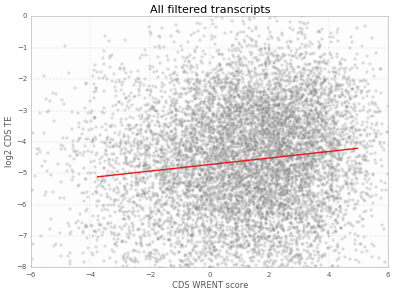

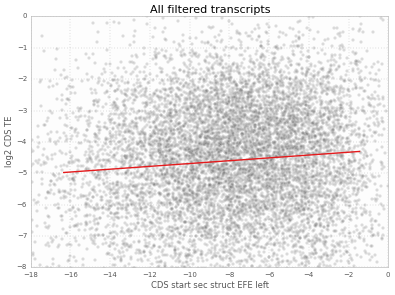

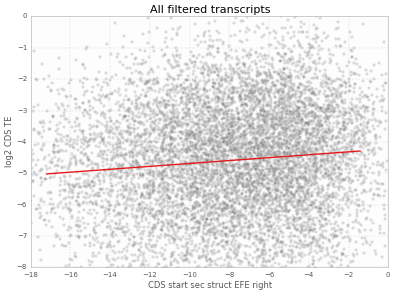

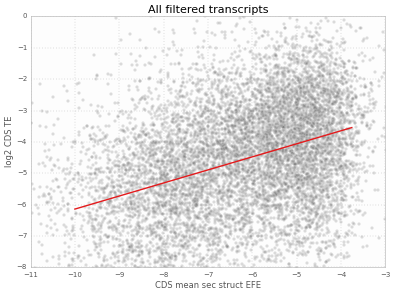

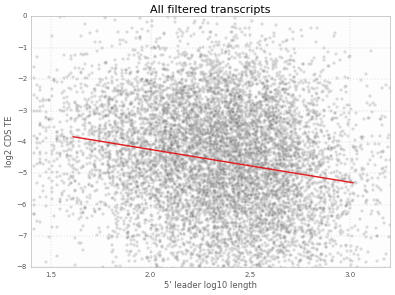

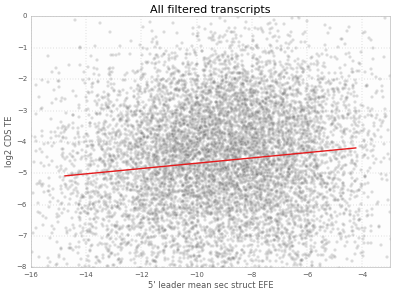

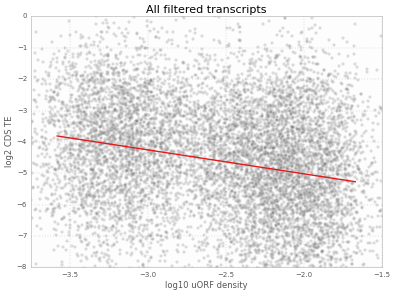

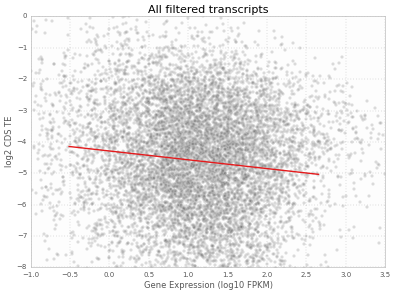

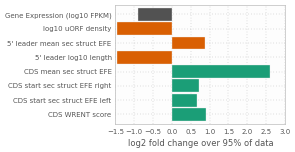

In [21]:
individual_correlations(("CDS", "5' leader", "others"), parameters, "All filtered transcripts", df_main_filtered)

**Supp Fig 8a, Supp Table 2**: Verifying correlation of individual CDS sequence features to CDS TE for transcripts with uORFs

### Individual correlations with CDS TE, filtered transcripts with uORFs

linear correlation           p  \
Gene Expression (log10 FPKM)             -0.07531   2.638e-08   
log10 uORF density                       -0.06357   2.671e-06   
5' leader mean sec struct EFE              0.1427   4.344e-26   
5' leader log10 length                    -0.1129   6.469e-17   
CDS mean sec struct EFE                    0.3607  1.917e-166   
CDS start sec struct EFE right             0.1032   2.238e-14   
CDS start sec struct EFE left              0.1058   4.924e-15   
CDS WRENT score                           0.08637   1.727e-10   

                               fold change over 95% of data  
Gene Expression (log10 FPKM)                         0.6528  
log10 uORF density                                   0.7127  
5' leader mean sec struct EFE                         2.171  
5' leader log10 length                               0.5233  
CDS mean sec struct EFE                               6.038  
CDS start sec struct EFE right                        1.741  
CDS start sec struct EFE left                         1.772  
CDS WRENT score                                       1.609

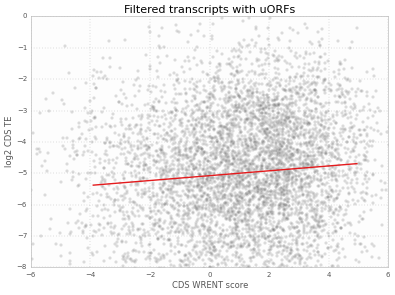

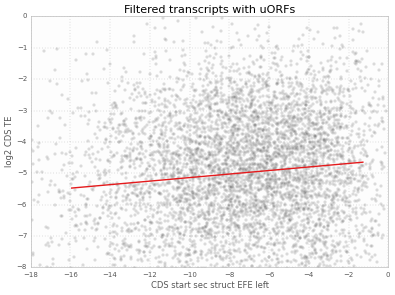

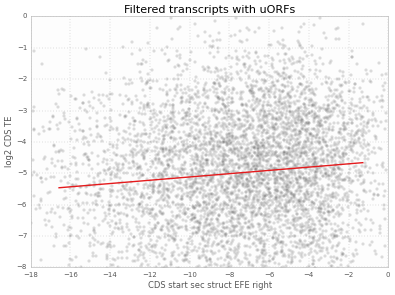

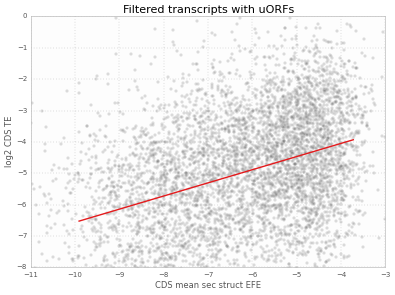

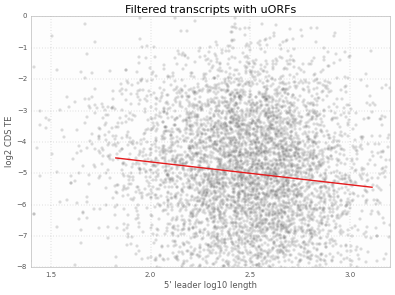

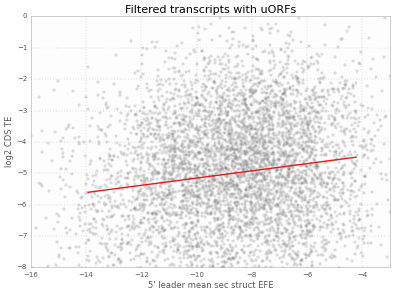

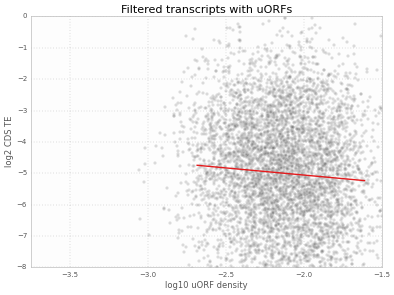

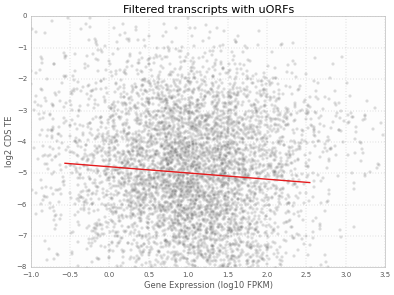

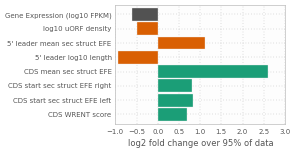

In [22]:
individual_correlations(("CDS", "5' leader", "others"), parameters, "Filtered transcripts with uORFs", with_uORFs)

**Supp Fig 8g, Supp Table 2**: Verifying correlation of individual CDS sequence features to CDS TE for transcripts with no uORFs

### Individual correlations with CDS TE, filtered transcripts without uORFs

linear correlation           p  \
Gene Expression (log10 FPKM)               -0.244   5.839e-53   
5' leader mean sec struct EFE              0.2312   3.378e-46   
5' leader log10 length                   -0.02274      0.1597   
CDS mean sec struct EFE                    0.4038  1.556e-145   
CDS start sec struct EFE right             0.1696   4.383e-26   
CDS start sec struct EFE left              0.1677   1.539e-25   
CDS WRENT score                            0.1228   2.526e-14   

                               fold change over 95% of data  
Gene Expression (log10 FPKM)                         0.2772  
5' leader mean sec struct EFE                          3.29  
5' leader log10 length                               0.8924  
CDS mean sec struct EFE                               6.806  
CDS start sec struct EFE right                        2.327  
CDS start sec struct EFE left                         2.319  
CDS WRENT score                                        1.85

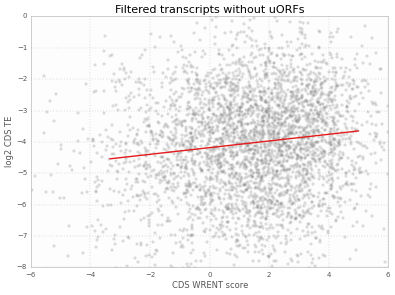

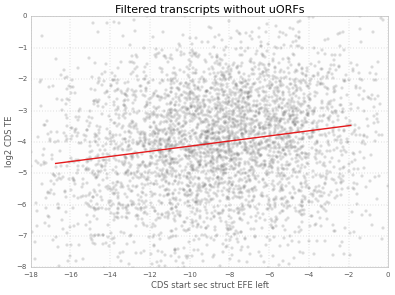

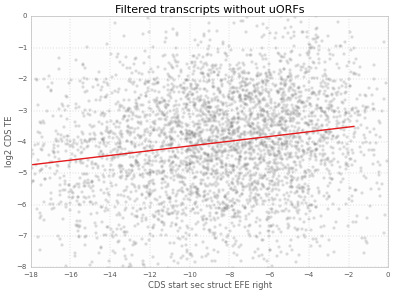

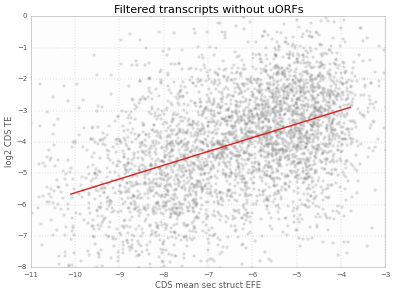

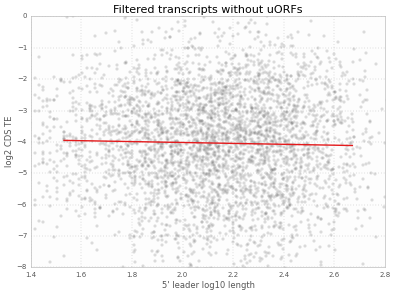

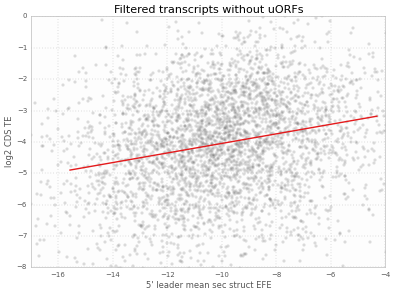

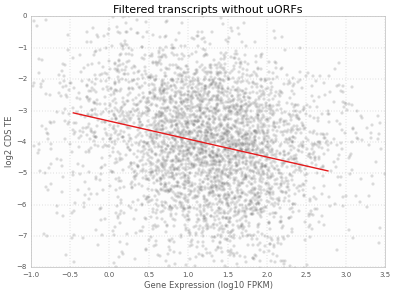

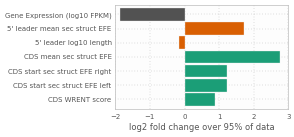

In [23]:
individual_correlations(("CDS", "5' leader (fixed uORFs)", "others"), parameters, "Filtered transcripts without uORFs", no_uORFs)

#### Integrating various sequence features in linear model for CDS TE

Linear modelling of uORF repressiveness with uORF, CDS and 5' leader sequence features. Scatter plots show the relationship of uORF repressiveness to a combined score integrating the various sequence features, while the red line indicates the regression (ridge) line; the relative contributions of individual sequence features is shown in the bar graphs below.

The results of using various sequence feature sets to model uORF repressiveness is summarized in a table, comparing the linear correlation and prediction errors (using the predicted residual sum of squares or PRESS statistic).

**Fig 3f-g, Table 1, Supp Fig 7c-h**: Transcripts with one non-overlapping uORF

CDS sequence features

Relative contribution per unit 2fold change
Sequence feature                                                          
CDS mean sec struct EFE                       0.7598                 1.389
CDS start sec struct EFE right               0.07626                0.3214
CDS start sec struct EFE left                 0.2927                 1.174
CDS WRENT score                              -0.0078              -0.01727

CDS + uORF sequence features

Relative contribution per unit 2fold change
Sequence feature                                                           
log uORF length                                0.0264              0.007245
uORF-CDS log distance                          0.2055                0.1019
uORF start sec struct EFE right                0.1812                0.7899
uORF start sec struct EFE left                 0.2029                0.8306
uORF WRENT score                              -0.2145               -0.5418
CDS mean sec struct EFE                        0.7453                 1.363
CDS start sec struct EFE right                0.05285                0.2227
CDS start sec struct EFE left                  0.2365                0.9489
CDS WRENT score                              -0.01076              -0.02382

CDS + 5' leader (fixed uORFs) sequence features

Relative contribution per unit 2fold change
Sequence feature                                                          
5' leader mean sec struct EFE                 0.5621                  1.35
5' leader log10 length                        0.1305               0.02716
CDS mean sec struct EFE                       0.6938                 1.269
CDS start sec struct EFE right               0.04625                0.1949
CDS start sec struct EFE left                 0.1234                 0.495
CDS WRENT score                              0.04074               0.09018

CDS + 5' leader (fixed uORFs) + uORF sequence features

Relative contribution per unit 2fold change
Sequence feature                                                           
log uORF length                               -0.1074              -0.02948
uORF-CDS log distance                        0.009889              0.004904
uORF start sec struct EFE right               0.05324                 0.232
uORF start sec struct EFE left                0.06586                0.2697
uORF WRENT score                              -0.2085               -0.5265
5' leader mean sec struct EFE                   0.476                 1.143
5' leader log10 length                         0.2954               0.06149
CDS mean sec struct EFE                        0.7068                 1.292
CDS start sec struct EFE right                0.03851                0.1623
CDS start sec struct EFE left                  0.1383                 0.555
CDS WRENT score                               0.01504               0.03329

Pearson r          p Fold change  PRESS  \
Sequence feature set                                                           
CDS                                     0.4901  3.442e-42       9.979  1,908   
CDS + uORF                              0.5362    1.2e-51        13.8  1,820   
CDS + 5' leader (fixed uORFs)           0.5417   6.81e-53       13.68  1,783   
CDS + 5' leader (fixed uORFs) + uORF    0.5612   1.93e-57       14.79  1,758   

                                       RESS    n  
Sequence feature set                              
CDS                                   1,884  677  
CDS + uORF                            1,766  677  
CDS + 5' leader (fixed uORFs)         1,751  677  
CDS + 5' leader (fixed uORFs) + uORF  1,698  677

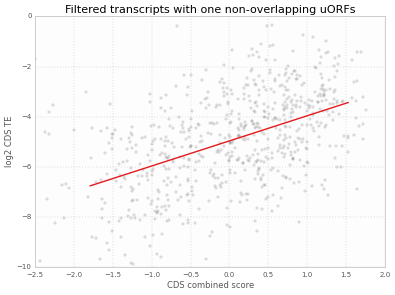

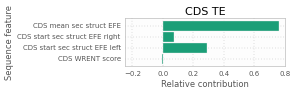

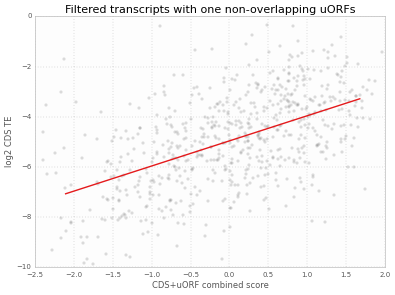

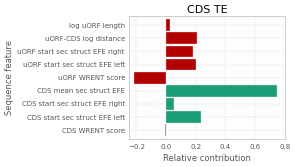

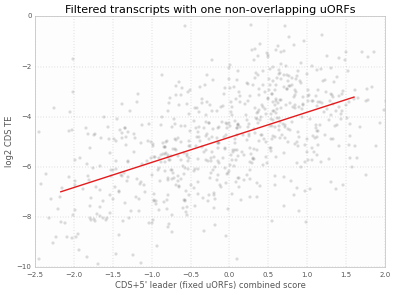

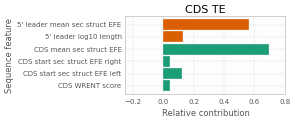

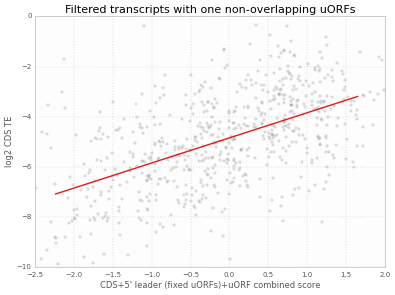

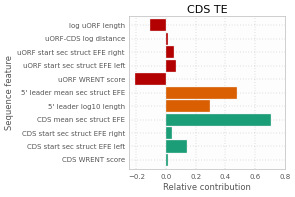

In [24]:
opt = ["5' leader (fixed uORFs)", "uORF"]
# opt = ["5' leader", "uORF"]
permutes = [[i, j] for i in (False, True) for j in (False, True)]
regressor_sets = [["CDS",] + [opt[i] for i, j in enumerate(permute) if j] for permute in permutes]

lin_regress_sets_RidgeCV(regressor_sets, parameters, "Filtered transcripts with one non-overlapping uORFs",
                         one_non_overlapping_uORF, "log2_CDS_TE", "log2 CDS TE", ((-2.5, 2), (-10, 0)), (-0.25, 0.8))

**Supp Fig S8b-c, e-f, h-i, Supp Table 3**: All filtered transcripts, transcripts with uORFs, transcripts without uORFs

**All filtered transcripts**

CDS sequence features

Relative contribution per unit 2fold change
Sequence feature                                                          
CDS mean sec struct EFE                       0.7359                 1.276
CDS start sec struct EFE right              -0.05224               -0.2158
CDS start sec struct EFE left               -0.00926              -0.03596
CDS WRENT score                               0.1394                0.3103

CDS + 5' leader sequence features

Relative contribution per unit 2fold change
Sequence feature                                                          
log10 uORF density                           -0.4871               -0.2777
5' leader mean sec struct EFE                 0.3295                0.8955
5' leader log10 length                       -0.3414               -0.1207
CDS mean sec struct EFE                       0.6923                   1.2
CDS start sec struct EFE right              -0.01086              -0.04485
CDS start sec struct EFE left               -0.00191             -0.007415
CDS WRENT score                              0.08902                0.1982

Pearson r           p Fold change      PRESS       RESS  \
Sequence feature set                                                           
CDS                     0.3643  9.012e-285       6.456   3.23e+04  3.227e+04   
CDS + 5' leader         0.4737           0       12.71  2.891e+04  2.886e+04   

                          n  
Sequence feature set         
CDS                   9,136  
CDS + 5' leader       9,136

**Filtered transcripts with uORFs**

CDS sequence features

Relative contribution per unit 2fold change
Sequence feature                                                          
CDS mean sec struct EFE                       0.7444                 1.297
CDS start sec struct EFE right              -0.05245                 -0.21
CDS start sec struct EFE left                 0.0102                0.0389
CDS WRENT score                              0.08611                0.1947

CDS + 5' leader sequence features

Relative contribution per unit 2fold change
Sequence feature                                                          
log10 uORF density                            -0.363               -0.1024
5' leader mean sec struct EFE                 0.3716                0.9312
5' leader log10 length                       -0.3517               -0.1105
CDS mean sec struct EFE                       0.6879                 1.199
CDS start sec struct EFE right                -0.044               -0.1762
CDS start sec struct EFE left               -0.01593              -0.06079
CDS WRENT score                              0.08012                0.1811

Pearson r           p Fold change      PRESS       RESS  \
Sequence feature set                                                           
CDS                     0.3637  2.419e-169       6.141  1.936e+04  1.933e+04   
CDS + 5' leader         0.4179  2.502e-228       9.146  1.843e+04  1.838e+04   

                          n  
Sequence feature set         
CDS                   5,426  
CDS + 5' leader       5,426

**Filtered transcripts without uORFs**

CDS sequence features

Relative contribution per unit 2fold change
Sequence feature                                                          
CDS mean sec struct EFE                       0.7153                 1.228
CDS start sec struct EFE right               0.05585                0.2357
CDS start sec struct EFE left                 0.1315                0.5065
CDS WRENT score                              0.08825                0.1908

CDS + 5' leader (fixed uORFs) sequence features

Relative contribution per unit 2fold change
Sequence feature                                                          
5' leader mean sec struct EFE                 0.3226                0.9116
5' leader log10 length                      -0.06079              -0.01794
CDS mean sec struct EFE                       0.6983                 1.199
CDS start sec struct EFE right               0.03823                0.1614
CDS start sec struct EFE left                0.02346               0.09039
CDS WRENT score                               0.0966                0.2089

Pearson r           p Fold change      PRESS  \
Sequence feature set                                                         
CDS                              0.4163  1.912e-155       7.442  1.071e+04   
CDS + 5' leader (fixed uORFs)     0.445  5.847e-180       8.512   1.04e+04   

                                    RESS      n  
Sequence feature set                             
CDS                            1.069e+04  3,710  
CDS + 5' leader (fixed uORFs)  1.037e+04  3,710

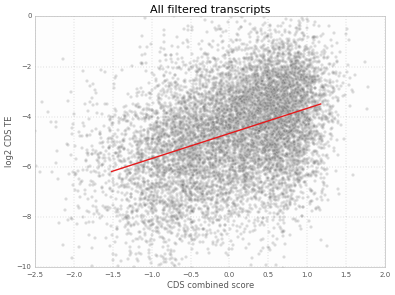

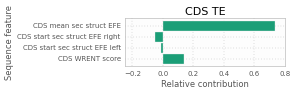

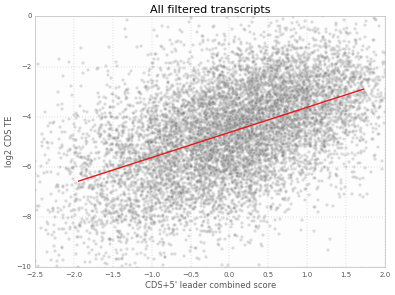

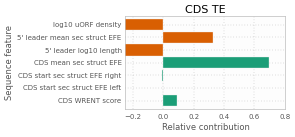

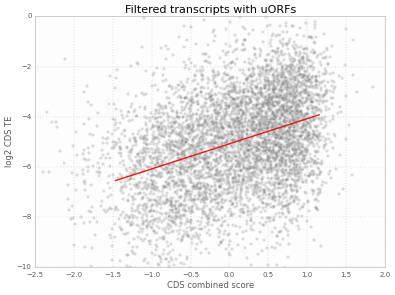

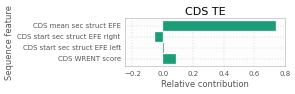

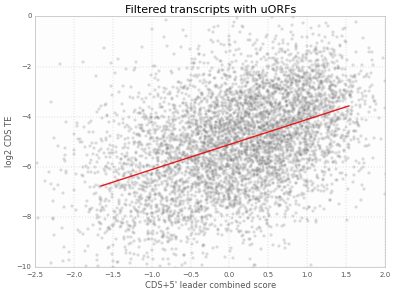

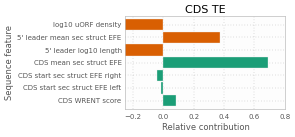

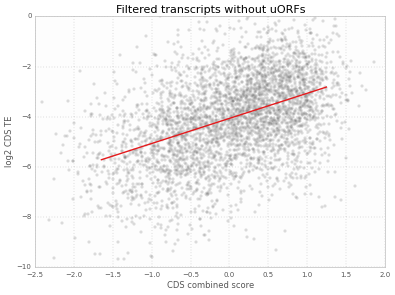

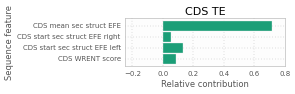

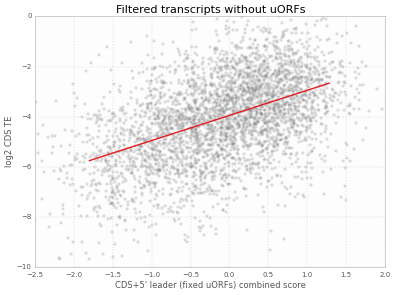

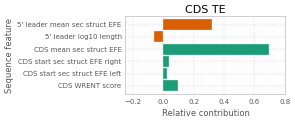

In [25]:
for t_set, t_set_label, UTR5_type in zip((df_main_filtered, with_uORFs, no_uORFs),
                                         ("All filtered transcripts",
                                          "Filtered transcripts with uORFs",
                                          "Filtered transcripts without uORFs"),
                                         ("5' leader", "5' leader", "5' leader (fixed uORFs)")):
    display(Markdown("**" + t_set_label + "**"))
    lin_regress_sets_RidgeCV([["CDS",], ["CDS", UTR5_type]], parameters, t_set_label,
                             t_set, "log2_CDS_TE", "log2 CDS TE", ((-2.5, 2), (-10, 0)), (-0.25, 0.8))

#### Tracking correlations amongst 5' leader sequence features

**Supp Fig S14a:** Correlations between 5' leader GC content, density of uORFs and mean secondary structure EFE

log10 density of uORFs  GC content  \
log10 density of uORFs                1.000000   -0.392773   
GC content                           -0.392773    1.000000   
Mean sec struct EFE                   0.288289   -0.886569   

                        Mean sec struct EFE  
log10 density of uORFs             0.288289  
GC content                        -0.886569  
Mean sec struct EFE                1.000000

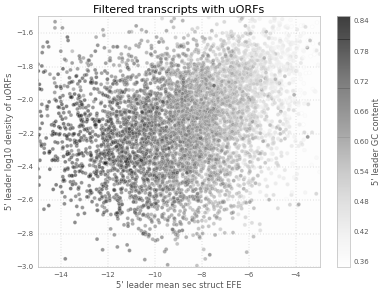

In [26]:
parameters = ["UTR5_GC", "UTR5_mean_ssefe_35"]
data = clean(with_uORFs[["log_num_uORFs_density",] + parameters])

ax = plt.scatter(data.UTR5_mean_ssefe_35, data.log_num_uORFs_density, c=data.UTR5_GC,
                 vmin=0.35, vmax=0.85, cmap="Greys", s=30, alpha=0.5)

plt.xlim(-15, -3)
plt.xlabel("5' leader mean sec struct EFE")
plt.ylim(-3, -1.5)
plt.ylabel("5' leader log10 density of uORFs")
plt.title("Filtered transcripts with uORFs")
plt.colorbar(ax, label="5' leader GC content")

data.columns = ["log10 density of uORFs", "GC content", "Mean sec struct EFE"]
data.corr()

Individual correlations between 5' leader GC content, density of uORFs and mean secondary structure EFE

5' leader log10 uORF density against 5' leader GC content

Correlation\ncoefficient     p-value
Pearson linear                  -0.3928  1.236e-199
Spearman rank                   -0.3949  5.146e-202

5' leader log10 uORF density against 5' leader mean sec struct EFE

Correlation\ncoefficient     p-value
Pearson linear                   0.2883  2.384e-104
Spearman rank                     0.318  8.778e-128

5' leader mean sec struct EFE against 5' leader GC content

Correlation\ncoefficient p-value
Pearson linear                  -0.8866       0
Spearman rank                   -0.8923       0

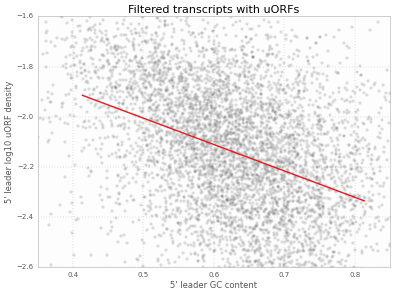

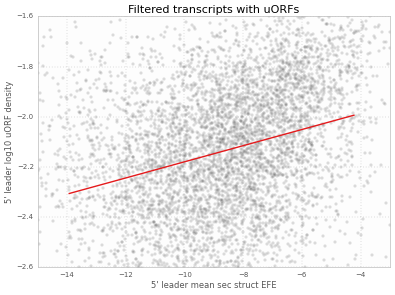

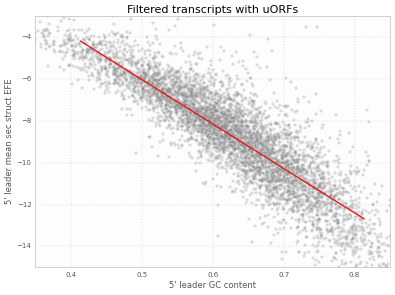

In [27]:
parameters = ["UTR5_GC", "UTR5_mean_ssefe_35"]
data = clean(with_uORFs[["log_num_uORFs_density",] + parameters])

for parameter, parameter_label, limits in zip(parameters,
                                              ("5' leader GC content", "5' leader mean sec struct EFE"),
                                              ((0.35, 0.85), (-15, -3))):
    
    scatter_linear_trend(data[parameter], data.log_num_uORFs_density,
                         parameter_label, "5' leader log10 uORF density")
    plt.xlim(*limits)
    plt.ylim(-2.6, -1.6)
    plt.title("Filtered transcripts with uORFs")

scatter_linear_trend(data.UTR5_GC, data.UTR5_mean_ssefe_35,
                     "5' leader GC content", "5' leader mean sec struct EFE")
plt.xlim(0.35, 0.85)
plt.ylim(-15, -3)
plt.title("Filtered transcripts with uORFs")

**Supp Fig S14b:** Correlations between select sequence parameters, subsetted by number of uORFs per transcripts.

In [28]:
parameters = DataFrame({"log_CDS_TE": {"label": "log10 CDS TE",
                                       "limits": (-2.5, 0)},
                        "log_UTR5_TE": {"label": "log10 5' leader TE",
                                        "limits": (-3.5, 0)},
                        "log_CDS_density": {"label": "log10 CDS RP read density",
                                            "limits": (-2.5, 1.5)},
                        "log_UTR5_density": {"label": "log10 5' leader RP read density",
                                             "limits": (-3, 1)},
                        "log_Gene_Expression_FPKM": {"label": "log10 gene expression (FPKM)",
                                                     "limits": (-1, 2.5)},
                        "log_UTR5_length": {"label": "log10 5' leader length",
                                            "limits": (1.8, 3)},
                        "log_num_uORFs_density": {"label": "log10 5' leader density of uORFs",
                                                  "limits": (-3, -1.5)},
                        "UTR5_GC": {"label": "5' leader GC content",
                                    "limits": (0.35, 0.85)},
                        "UTR5_mean_ssefe_35": {"label": "5' leader mean sec struct EFE",
                                               "limits": (-16, -4)}})

c:\Anaconda2\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
c:\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


log10 5' leader length against 5' leader GC content

Correlation\ncoefficient    p-value
1 uORF                     0.1133  2.026e-07
2 uORFs                    0.1425  1.507e-06
3 uORFs                    0.2524  4.301e-11
4+ uORFs                  0.01049      0.679
All                        -0.181  2.524e-41

5' leader mean sec struct EFE against 5' leader GC content

Correlation\ncoefficient     p-value
1 uORF                    -0.8344           0
2 uORFs                   -0.8714           0
3 uORFs                   -0.8934  6.855e-232
4+ uORFs                   -0.923           0
All                       -0.8866           0

log10 5' leader density of uORFs against 5' leader GC content

Correlation\ncoefficient     p-value
1 uORF                    -0.1133   2.026e-07
2 uORFs                   -0.1425   1.507e-06
3 uORFs                   -0.2524   4.301e-11
4+ uORFs                  -0.4887   2.458e-94
All                       -0.3908  3.262e-198

5' leader GC content against log10 5' leader length

Correlation\ncoefficient    p-value
1 uORF                     0.1133  2.026e-07
2 uORFs                    0.1425  1.507e-06
3 uORFs                    0.2524  4.301e-11
4+ uORFs                  0.01049      0.679
All                        -0.181  2.524e-41

5' leader mean sec struct EFE against log10 5' leader length

Correlation\ncoefficient    p-value
1 uORF                    0.01452     0.5085
2 uORFs                  -0.05899    0.04743
3 uORFs                   -0.1646  2.041e-05
4+ uORFs                 0.003726     0.8832
All                        0.2167  1.187e-58

log10 5' leader density of uORFs against log10 5' leader length

Correlation\ncoefficient    p-value
1 uORF                         -1          0
2 uORFs                        -1          0
3 uORFs                        -1          0
4+ uORFs                  -0.4378  5.712e-74
All                       -0.2609  2.008e-85

5' leader GC content against 5' leader mean sec struct EFE

Correlation\ncoefficient     p-value
1 uORF                    -0.8344           0
2 uORFs                   -0.8714           0
3 uORFs                   -0.8934  6.855e-232
4+ uORFs                   -0.923           0
All                       -0.8866           0

log10 5' leader length against 5' leader mean sec struct EFE

Correlation\ncoefficient    p-value
1 uORF                    0.01452     0.5085
2 uORFs                  -0.05899    0.04743
3 uORFs                   -0.1646  2.041e-05
4+ uORFs                 0.003726     0.8832
All                        0.2167  1.187e-58

log10 5' leader density of uORFs against 5' leader mean sec struct EFE

Correlation\ncoefficient     p-value
1 uORF                   -0.01452      0.5085
2 uORFs                   0.05899     0.04743
3 uORFs                    0.1646   2.041e-05
4+ uORFs                   0.4032   5.514e-62
All                        0.2883  2.384e-104

5' leader GC content against log10 5' leader density of uORFs

Correlation\ncoefficient     p-value
1 uORF                    -0.1133   2.026e-07
2 uORFs                   -0.1425   1.507e-06
3 uORFs                   -0.2524   4.301e-11
4+ uORFs                  -0.4887   2.458e-94
All                       -0.3908  3.262e-198

c:\Anaconda2\lib\site-packages\matplotlib\pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


log10 5' leader length against log10 5' leader density of uORFs

Correlation\ncoefficient    p-value
1 uORF                         -1          0
2 uORFs                        -1          0
3 uORFs                        -1          0
4+ uORFs                  -0.4378  5.712e-74
All                       -0.2609  2.008e-85

5' leader mean sec struct EFE against log10 5' leader density of uORFs

Correlation\ncoefficient     p-value
1 uORF                   -0.01452      0.5085
2 uORFs                   0.05899     0.04743
3 uORFs                    0.1646   2.041e-05
4+ uORFs                   0.4032   5.514e-62
All                        0.2883  2.384e-104

log10 CDS TE against 5' leader GC content

Correlation\ncoefficient    p-value
1 uORF                    -0.2896  1.013e-41
2 uORFs                   -0.2613  4.192e-19
3 uORFs                   -0.2827  1.191e-13
4+ uORFs                  -0.1238  9.567e-07
All                        -0.145  5.795e-27

log10 CDS TE against log10 5' leader length

Correlation\ncoefficient    p-value
1 uORF                    -0.0404    0.06464
2 uORFs                 -0.006194     0.8352
3 uORFs                  0.003356     0.9313
4+ uORFs                 -0.04079     0.1075
All                       -0.1129  6.469e-17

log10 CDS TE against 5' leader mean sec struct EFE

Correlation\ncoefficient    p-value
1 uORF                     0.2678   2.07e-35
2 uORFs                    0.2371  6.635e-16
3 uORFs                    0.2721  1.022e-12
4+ uORFs                   0.1132  7.551e-06
All                        0.1427  4.344e-26

log10 CDS TE against log10 5' leader density of uORFs

Correlation\ncoefficient    p-value
1 uORF                     0.0404    0.06464
2 uORFs                  0.006194     0.8352
3 uORFs                 -0.003356     0.9313
4+ uORFs                  0.01989     0.4328
All                      -0.06357  2.671e-06

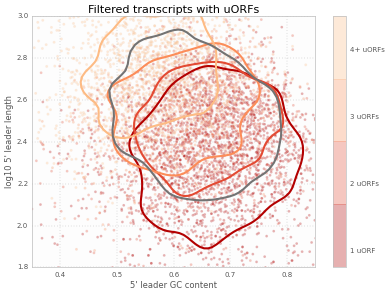

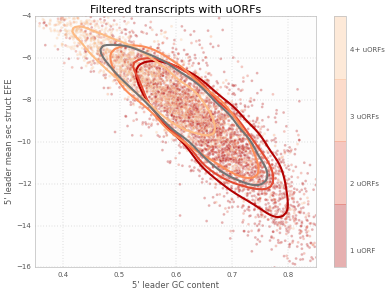

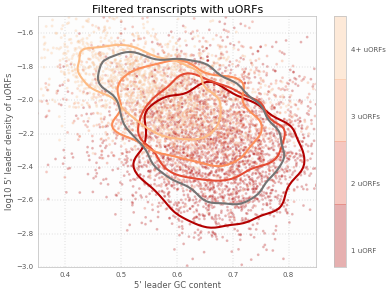

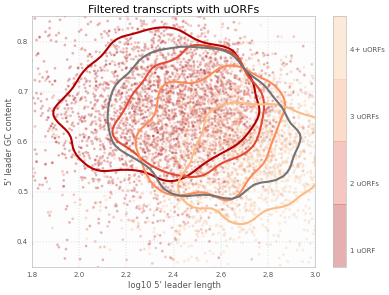

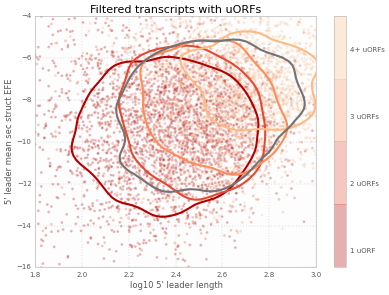

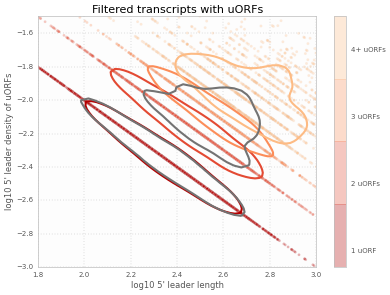

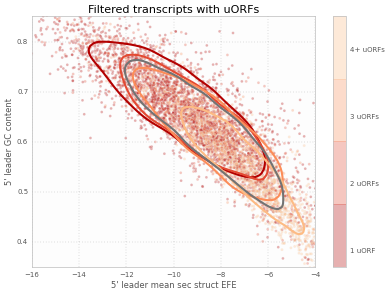

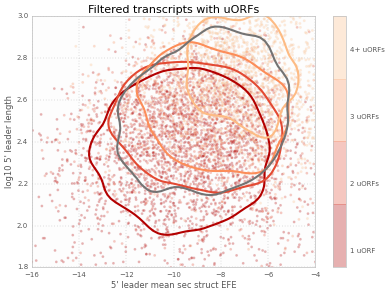

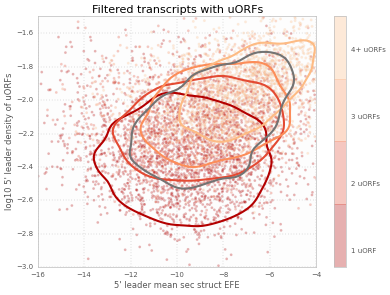

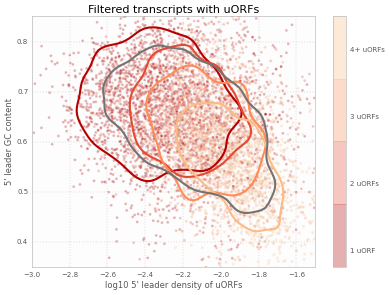

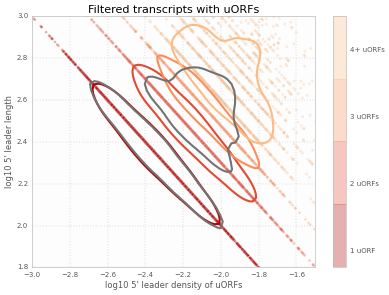

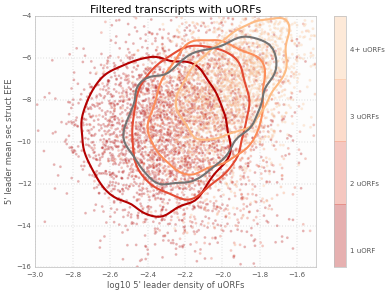

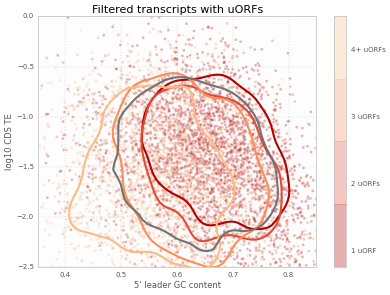

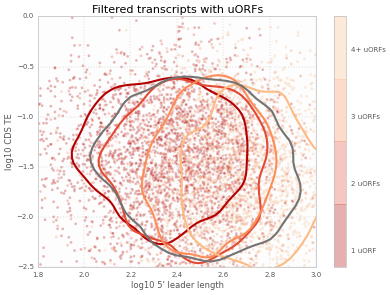

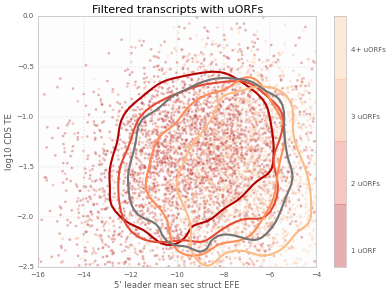

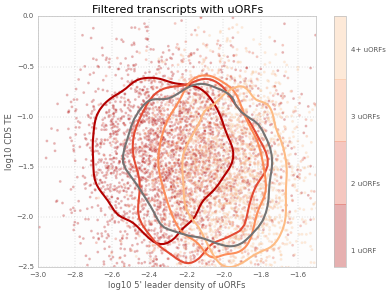

In [29]:
dataset, dataset_label = with_uORFs, "Filtered transcripts with uORFs"
comparisons = [("UTR5_GC", "log_UTR5_length"),
               ("UTR5_GC", "UTR5_mean_ssefe_35"),
               ("UTR5_GC", "log_num_uORFs_density"),
               ("log_UTR5_length", "UTR5_GC"),
               ("log_UTR5_length", "UTR5_mean_ssefe_35"),
               ("log_UTR5_length", "log_num_uORFs_density"),
               ("UTR5_mean_ssefe_35", "UTR5_GC"),
               ("UTR5_mean_ssefe_35", "log_UTR5_length"),
               ("UTR5_mean_ssefe_35", "log_num_uORFs_density"),
               ("log_num_uORFs_density", "UTR5_GC"),
               ("log_num_uORFs_density", "log_UTR5_length"),
               ("log_num_uORFs_density", "UTR5_mean_ssefe_35"),
               ("UTR5_GC", "log_CDS_TE"),
               ("log_UTR5_length", "log_CDS_TE"),
               ("UTR5_mean_ssefe_35", "log_CDS_TE"),
               ("log_num_uORFs_density", "log_CDS_TE")]

for x, y in comparisons:
    scatter_by_uORF_num(dataset, dataset_label, x, y,
                        parameters[x].label, parameters[y].label,
                        parameters[x].limits, parameters[y].limits)